In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import cv2
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
width    = 28
height   = 28
channels = 1
epochs   = 1000

img_shape = (width, height, channels)

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 32

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

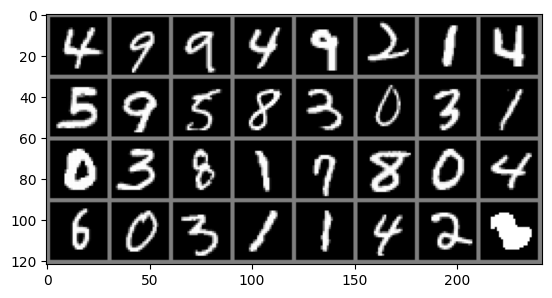

    4     9     9     4     9     2     1     4     5     9     5     8     3     0     3     1     0     3     8     1     7     8     0     4     6     0     3     1     1     4     2     3


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % labels[j].item() for j in range(batch_size)))

In [5]:


class Generator(nn.Module):
    def __init__(self):
      super(Generator, self).__init__()
      self.model = nn.Sequential(
        nn.Linear(100, 256),
        nn.LeakyReLU(0.25),
        nn.BatchNorm1d(256, momentum=0.8),

        nn.Linear(256, 512),
        nn.LeakyReLU(0.2),
        nn.BatchNorm1d(512, momentum=0.8),

        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2),
        nn.BatchNorm1d(1024, momentum=0.8),

        nn.Linear(1024, width  * height * channels),
        nn.Tanh(),
    )

    def forward(self, x):
        x = self.model(x)
        return x.view(-1, width, height, channels)


G = Generator().cuda()
summary(G, (100, ), batch_size=-1, device='cuda')
print("_____________________ Generator Created_____________________")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          25,856
         LeakyReLU-2                  [-1, 256]               0
       BatchNorm1d-3                  [-1, 256]             512
            Linear-4                  [-1, 512]         131,584
         LeakyReLU-5                  [-1, 512]               0
       BatchNorm1d-6                  [-1, 512]           1,024
            Linear-7                 [-1, 1024]         525,312
         LeakyReLU-8                 [-1, 1024]               0
       BatchNorm1d-9                 [-1, 1024]           2,048
           Linear-10                  [-1, 784]         803,600
             Tanh-11                  [-1, 784]               0
Total params: 1,489,936
Trainable params: 1,489,936
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [6]:

class Discriminator(nn.Module):
    def __init__(self):
      super(Discriminator, self).__init__()
      self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(width * height * channels, width * height * channels),
        nn.LeakyReLU(0.2),
        nn.Linear( width * height * channels, (width * height * channels)//2),
        nn.LeakyReLU(0.2),
        nn.Linear((width * height * channels)//2, 1),
        nn.Sigmoid(),
    )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)

        return x

D = Discriminator().cuda()
summary(D, img_shape, batch_size=-1, device='cuda')
print("____________________ Discriminator Created____________________")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 784]         615,440
         LeakyReLU-3                  [-1, 784]               0
            Linear-4                  [-1, 392]         307,720
         LeakyReLU-5                  [-1, 392]               0
            Linear-6                    [-1, 1]             393
           Sigmoid-7                    [-1, 1]               0
Total params: 923,553
Trainable params: 923,553
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 3.52
Estimated Total Size (MB): 3.55
----------------------------------------------------------------
____________________ Discriminator Created____________________


In [7]:
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=8e-8)
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=8e-8)

epochs  = 10
adversarial_loss = nn.BCELoss().cuda()

losses_G = []
losses_D = []
samples = []

In [8]:
for epoch in range(epochs):
    for (i, (imgs, _)) in enumerate(trainloader, start=1):
        valid = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        real_imgs = Variable(imgs.type(torch.cuda.FloatTensor))


        optimizer_G.zero_grad()

        z = Variable(torch.cuda.FloatTensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

        gen_imgs = G(z)

        g_loss = adversarial_loss(D(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()


        optimizer_D.zero_grad()

        real_loss = adversarial_loss(D(real_imgs), valid)
        fake_loss = adversarial_loss(D(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        if epoch % 1 == 0 and i == len(trainloader):
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, epochs, i, len(trainloader), d_loss.item(), g_loss.item())
            )

            losses_G.append(g_loss.item())
            losses_D.append(d_loss.item())
            samples.append(gen_imgs)


/tmp/ipython-input-1223868319.py:3: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  valid = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)


[Epoch 0/10] [Batch 1875/1875] [D loss: 0.641888] [G loss: 0.619388]
[Epoch 1/10] [Batch 1875/1875] [D loss: 0.631629] [G loss: 1.176425]
[Epoch 2/10] [Batch 1875/1875] [D loss: 0.664141] [G loss: 0.478466]
[Epoch 3/10] [Batch 1875/1875] [D loss: 0.611456] [G loss: 1.166811]
[Epoch 4/10] [Batch 1875/1875] [D loss: 0.572634] [G loss: 0.826499]
[Epoch 5/10] [Batch 1875/1875] [D loss: 0.661875] [G loss: 1.006548]
[Epoch 6/10] [Batch 1875/1875] [D loss: 0.633333] [G loss: 0.729922]
[Epoch 7/10] [Batch 1875/1875] [D loss: 0.658125] [G loss: 0.599108]
[Epoch 8/10] [Batch 1875/1875] [D loss: 0.548520] [G loss: 1.108409]
[Epoch 9/10] [Batch 1875/1875] [D loss: 0.543649] [G loss: 0.838082]


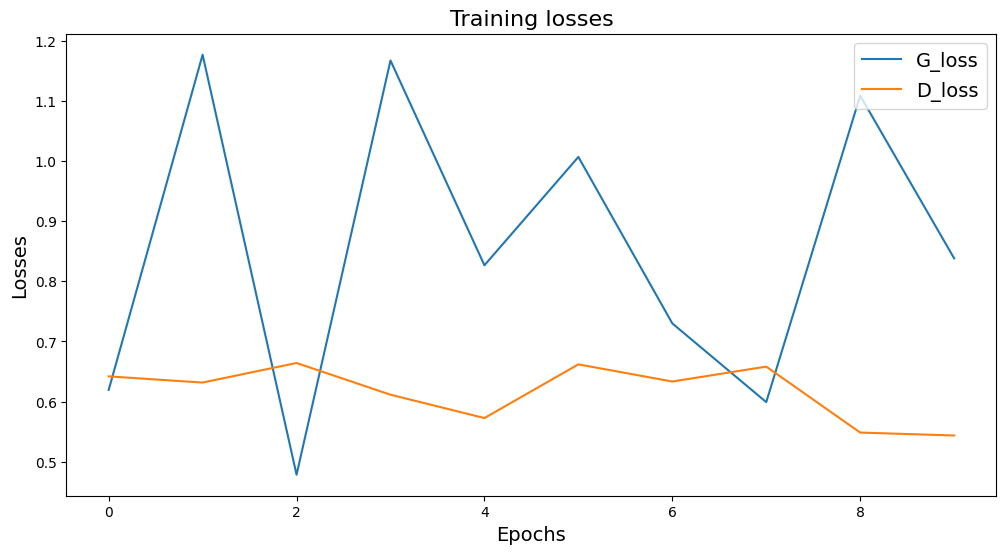

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(list(range((len(losses_G)//10)*10)), losses_G, label="G_loss")
plt.plot(list(range((len(losses_D)//10)*10)), losses_D, label="D_loss")

plt.title("Training losses", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Losses", fontsize=14)
plt.legend(loc="upper right", fontsize=14)
plt.show()

    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________


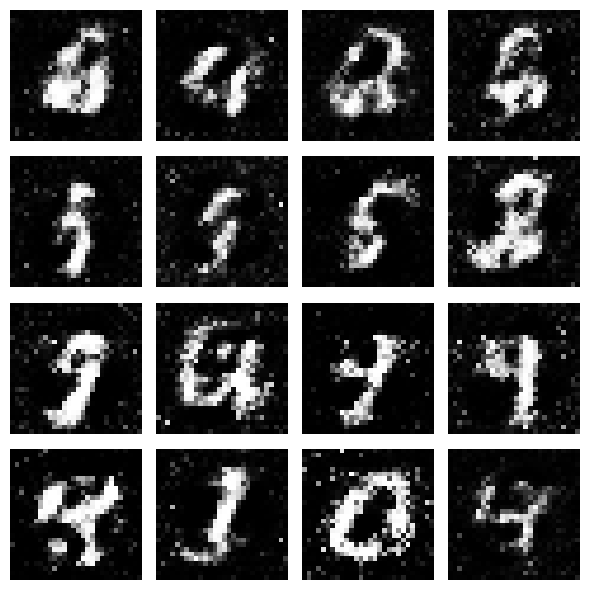

In [11]:
i = 0
for i in range(0, len(samples), 10):
    images = samples[i].data.cpu().numpy()
    print("    ____________________ Step = %d ____________________" % i*10)
    plt.figure(figsize=(6, 6))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [height, width])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    print("\n")

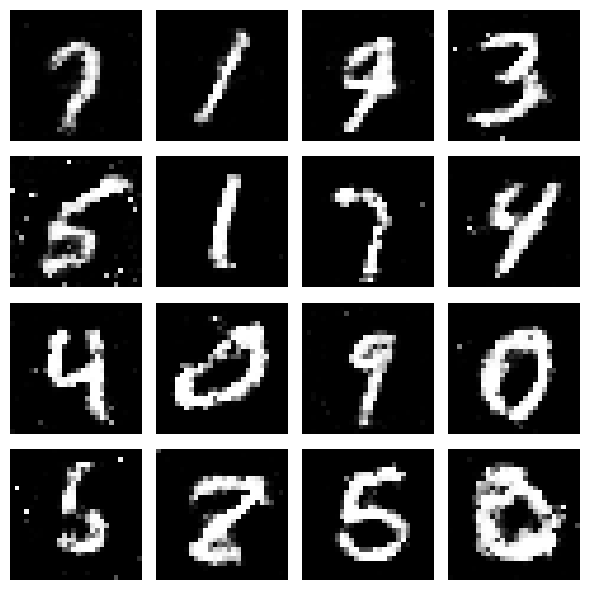

In [12]:
noise = torch.Tensor(np.random.normal(0, 1, (16, 100))).cuda()
gen_images = G(noise)
images = gen_images.data.cpu().numpy()
plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [height, width])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()